In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

# functions

## utils

In [3]:
ALL_COUMNS = [
    'PAN','PT1','PT2',
    
    'AxAN','AyAN','AzAN',
    'AxTM1','AyTM1','AzTM1',
    'AxTR1','AyTR1','AzTR1',
    'AxTM2','AyTM2','AzTM2',
    'AxTR2','AyTR2','AzTR2',
    
    'GxAN','GyAN','GzAN',
    'GxTM1','GyTM1','GzTM1',
    'GxTR1','GyTR1','GzTR1',
    'GxTM2','GyTM2','GzTM2',
    'GxTR2','GyTR2','GzTR2',
    
    'OFFSET_ms',
    'OFFSET_s',
]

P = ['PAN','PT1','PT2',]

AN = ['AxAN','AyAN','AzAN']
ATM1 = ['AxTM1','AyTM1','AzTM1']
ATR1 = ['AxTR1','AyTR1','AzTR1']
ATM2 = ['AxTM2','AyTM2','AzTM2']
ATR2 = ['AxTR2','AyTR2','AzTR2']

AT = ATM1 + ATR1 + ATM2 + ATR2
AT1 = ATM1 + ATR1
AT2 = ATM2 + ATR1
A = ATM1 + ATR1 + ATM2 + ATR2 + AN

GN = ['GxAN','GyAN','GzAN']
GTM1 = ['GxTM1','GyTM1','GzTM1']
GTR1 = ['GxTR1','GyTR1','GzTR1']
GTM2 = ['GxTM2','GyTM2','GzTM2']
GTR2 = ['GxTR2','GyTR2','GzTR2']

GT = GTM1 + GTR1 + GTM2 + GTR2
GT1 = GTM1 + GTR1
GT2 = GTM2 + GTR1
G = GTM1 + GTR1 + GTM2 + GTR2 + GN


## cleaning

In [4]:
import pandas as pd
import numpy as np
from typing import List
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from statsmodels.nonparametric.smoothers_lowess import lowess


def csv_shift(df: pd.DataFrame) -> pd.DataFrame:
    '''
    csv files have one separetor ";" at the end. Columns headers must be shifted
    '''
    df_res = pd.DataFrame()
    df_res['PAN'] = df.index
    idx_col = enumerate(df.columns)
    _ = idx_col.__next__() # to skip first iteration
    for idx, c in idx_col:
        df_res[c] = df.iloc[:, idx - 1].values

    return df_res

def timestamp(df: pd.DataFrame) -> pd.DataFrame:
    '''
    - set timestamp as index;
    - ordering by timestamp;
    - computing OFFSET_ms (millisecond)
    '''
    df['OFFSET_ms'] = df['TIMESTAMP'] - df['TIMESTAMP'].iloc[0]
    df['OFFSET_s'] = df['OFFSET_ms'] / 1_000
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'].values, unit='ms')

    df = df.set_index(df['OFFSET_s'].values)
    df = df.sort_index()

    return df


def dps_normalizaton(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    df[cols] /= 1_000
    return df

def moving_avarage(df: pd.DataFrame, cols: List[str], window='0.5s') -> pd.DataFrame:
    df = df.set_index(df['TIMESTAMP'].values)
    df[cols] = df[cols].rolling(window).mean()
    df = df.set_index(df['OFFSET_s'].values)
    return df

def drop_seconds(df: pd.DataFrame, sec: float) -> pd.DataFrame:
    df = df[df.index >= sec]
    df['OFFSET_ms'] -= df['OFFSET_ms'].iloc[0]
    df['OFFSET_s'] -= df['OFFSET_s'].iloc[0]
    return df

def _kalman_filter(df: pd.DataFrame, col: str, dt: float = 0.5) -> pd.DataFrame:
    dim_x = 2
    dim_z = 1

    kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    kf.F = np.array([[1, dt], # transizione dello stato
                     [0, 1]])
    kf.H = np.array([[1, 0]]) # Osservazione
    kf.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=1e-5) # rumore di processo
    kf.R = np.array([[0.1**2]]) # rumore di misura
    kf.P = np.array([[1, 0], # covarianza iniziaòe
                     [0, 1]])

    df[f'original_{col}'] = df[col]
    values = df[col].values
    filtered = [values[0]]
    kf.x = [values[0], 0]
    for value in values[1:]:
        kf.predict()
        kf.update([value])
        filtered.append(kf.x[0])
    df[col] = filtered
    return df

def kalman_filter(df: pd.DataFrame, cols: List[str], dt: float = 0.5) -> pd.DataFrame:
    for c in cols:
        df = _kalman_filter(df=df, col=c, dt=dt)
    return df


## Trasformations

### filters and new features

In [5]:
import numpy as np
from typing import Union, List
from scipy.integrate import cumulative_trapezoid
from functools import reduce 


def magnitudo(df: pd.DataFrame, cols_xyz: List[list], names_magnitudo: List[str]) -> pd.DataFrame:
    for col_xyz, name_magnitudo in zip(cols_xyz, names_magnitudo):
        df[name_magnitudo] = np.sqrt((df[col_xyz]**2).sum(axis=1))
    return df

def mask_data(df: pd.DataFrame, cols: List[str], cuts: List[float]) -> pd.DataFrame:
    masks = []
    for col, cut in zip(cols, cuts):
        masks.append(
            df[col] > cut
        )
    mask = reduce(lambda m1, m2: m1 & m2, masks)
    return df[mask]


def integrate_col(df: pd.DataFrame, col: str, offset_col: str = 'OFFSET_s') -> np.array:
    '''
    compute the integral function with trapezoid methods
    '''
    integral_values = np.zeros(df.shape[0])
    integral_values[1:] = cumulative_trapezoid(x=df[offset_col], y=df[col])
    return integral_values

def integrate_cols(df: pd.DataFrame, cols: List[str], offset_col: str = 'OFFSET_s') -> pd.DataFrame:
    '''
    compute the integral function with trapezoid methods of several cols.
    create in the dataframe the coluns "int_{column}"
    '''
    for c in cols:
        df[f'int_{c}'] = integrate_col(df=df, col=c, offset_col=offset_col)
    
    return df

def degree_to_rad(df: pd.DataFrame, cols: str) -> pd.DataFrame:
    df[cols] *= np.pi / 180 
    return df

def rotation_matrix(theta: np.array) -> np.array:
    '''
    given a vector of three angles in radiant,
    return the corrisponding 3x3 rotation matrix
    '''
    theta_x, theta_y, theta_z = theta
    cos_theta_x = np.cos(theta_x)
    sin_theta_x = np.sin(theta_x)
    cos_theta_y = np.cos(theta_y)
    sin_theta_y = np.sin(theta_y)
    cos_theta_z = np.cos(theta_z)
    sin_theta_z = np.sin(theta_z)
    R_x = np.array([
        [1, 0, 0],
        [0, cos_theta_x, -sin_theta_x],
        [0, sin_theta_x, cos_theta_x],
    ])
    R_y = np.array([
        [cos_theta_y, 0, sin_theta_y],
        [0, 1, 0],
        [-sin_theta_y, 0, cos_theta_y],
    ])
    R_z = np.array([
        [cos_theta_z, -sin_theta_z, 0],
        [sin_theta_z, cos_theta_z, 0],
        [0, 0, 1],
    ])

    return R_x.dot(R_y).dot(R_z)

def apply_rotation(df: pd.DataFrame, cols_xyz: List[str], rad_xyz: List[str]) -> pd.DataFrame:
    matrixes = (-df[rad_xyz]).apply(rotation_matrix, axis=1)
    vectors = df[cols_xyz].values

    new_coords = list(map(
        lambda M_v: M_v[0].dot(M_v[1]),
        zip(matrixes, vectors)
    ))
    df[[f'~{c}' for c in cols_xyz]] = np.stack(new_coords)
    return df

def diff_dt(df: pd.DataFrame, cols: list) -> pd.DataFrame:
    for c in cols:
        # df[f'dt_{c}'] = df[c].diff().div(df['OFFSET_s'].diff())
        df[f'dt_{c}'] = df[c].diff() / df['OFFSET_s'].diff().iloc[1:].mean()

    df = df.iloc[1:]

    return df

def _lowess_filter(df: pd.DataFrame, col: str, num_fit: int = 25) -> pd.DataFrame:
    x = df['OFFSET_s'].values
    y = df[col].values

    frac = num_fit / y.size  # Percentuale dei dati utilizzati per ciascun fit locale
    y_smoth = lowess(y, x, frac=frac)[:, 1]
    df[f'original_{col}'] = y
    df[col] = y_smoth

    return df

def lowess_filter(df: pd.DataFrame, cols: List[str], num_fit: int = 25) -> pd.DataFrame:
    for c in cols:
        df = _lowess_filter(df=df, col=c, num_fit=num_fit)
    return df


def _angle_beetwen_vectors(values_xyz: np.array) -> np.array:
    '''
    given a N x 3 array rappresenting the 3 coordinates of N vectors,
    compute angles between each vector and the previous.
    The first value is 0.

    return a N x 1 array
    '''
    values_norm = np.sqrt((values_xyz**2).sum(axis=1))
    scalar_product = (values_xyz[1:] * values_xyz[:-1]).sum(axis=1)
    product_norms = values_norm[1:] * values_norm[:1]
    
    cos_angles = np.clip(scalar_product / product_norms, -1, 1)
    _angles = np.arccos(cos_angles)
    angles = np.zeros_like(values_norm)
    angles[1:] = _angles

    return angles

def _cross_vectors(values_xyz: np.array) -> np.array:
    '''
    given a N x 3 array rappresenting the 3 coordinates of N vectors,
    compute the cross product between each vector and the next.
    The first value is [0,0,0].

    return a N x 3 array
    '''
    cross_products = np.zeros_like(values_xyz)
    cross_products[1:] = np.cross(values_xyz[:-1], values_xyz[1:])
    return cross_products

def angle_beetwen_vectors(df: pd.DataFrame, cols_xyz: List[List[str]], angles_names: List[str]) -> pd.DataFrame:
    for col_xyz, angle_name in zip(cols_xyz, angles_names):
        df[angle_name] = _angle_beetwen_vectors(df[col_xyz].values)
    return df

def angle_beetwen_cross_vectors(df: pd.DataFrame, cols_xyz: List[List[str]], angles_names: List[str]) -> pd.DataFrame:
    for col_xyz, angle_name in zip(cols_xyz, angles_names):
        cross_vectors = _cross_vectors(df[col_xyz].values)
        angles = np.zeros(cross_vectors.shape[0])
        angles[1:] = _angle_beetwen_vectors(cross_vectors[1:])
        df[angle_name] = angles 

    df = df.iloc[2:]

    return df

def clip(df: pd.DataFrame, cols: List[str], min_: Union[None, float], max_: Union[None, float]) -> pd.DataFrame:
    df[cols] = np.clip(df[cols], min_, max_)
    return df

def _single_point_filter(df: pd.DataFrame, col: str, margin: int = 4) -> pd.DataFrame:
    values = df[col].values
    for i in range(values.size):
        left_margin = max(i - margin, 0)
        right_margin = min(i + margin, values.size)
        if (values[left_margin: right_margin] > 0).sum() == 1:
            values[i] = 0

    df[col] = values
    return df

def single_point_filter(df: pd.DataFrame, cols: List[str], margin: int = 4) -> pd.DataFrame:
    for c in cols:
        df = _single_point_filter(df, col=c, margin=margin)
    return df

### Final transformation

In [6]:
def rotational_invariant_features(df: pd.DataFrame) -> pd.DataFrame:
    return df.pipe(csv_shift)\
      .pipe(timestamp)\
       .dropna()\
       .pipe(drop_seconds, sec=1)\
       .pipe(dps_normalizaton,
             cols=['GxTM1', 'GyTM1', 'GzTM1'])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'PAN','PT1','PT2',
    
                  'AxAN','AyAN','AzAN',
                  'AxTM1','AyTM1','AzTM1',
                  'AxTR1','AyTR1','AzTR1',
                  'AxTM2','AyTM2','AzTM2',
                  'AxTR2','AyTR2','AzTR2',
                  
                  'GxAN','GyAN','GzAN',
                  'GxTM1','GyTM1','GzTM1',
                  'GxTR1','GyTR1','GzTR1',
                  'GxTM2','GyTM2','GzTM2',
                  'GxTR2','GyTR2','GzTR2',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['AxTM1', 'AyTM1', 'AzTM1'],
                 ['AxTR1', 'AyTR1', 'AzTR1'],
                 ['AxTM2', 'AyTM2', 'AzTM2'],
                 ['AxTR2', 'AyTR2', 'AzTR2'],
                 ['AxAN', 'AyAN', 'AzAN'],
             ],
             names_magnitudo=[
                 'MAGNITUDO_TM1',
                 'MAGNITUDO_TR1',
                 'MAGNITUDO_TM2',
                 'MAGNITUDO_TR2',
                 'MAGNITUDO_AN',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['AxTM1', 'AyTM1', 'AzTM1'],
                 ['AxTR1', 'AyTR1', 'AzTR1'],
                 ['AxTM2', 'AyTM2', 'AzTM2'],
                 ['AxTR2', 'AyTR2', 'AzTR2'],
                 ['AxAN', 'AyAN', 'AzAN'],
             ],
             angles_names=[
                 'rad_TM1',
                 'rad_TR1',
                 'rad_TM2',
                 'rad_TR2',
                 'rad_AN',
            ])\
       .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['AxTM1', 'AyTM1', 'AzTM1'],
                 ['AxTR1', 'AyTR1', 'AzTR1'],
                 ['AxTM2', 'AyTM2', 'AzTM2'],
                 ['AxTR2', 'AyTR2', 'AzTR2'],
                 ['AxAN', 'AyAN', 'AzAN'],                 
             ],
             angles_names=[
                 'rad_cross_TM1',
                 'rad_cross_TR1',
                 'rad_cross_TM2',
                 'rad_cross_TR2',
                 'rad_cross_AN',                 
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross_TM1',
                 'rad_cross_TR1',
                 'rad_cross_TM2',
                 'rad_cross_TR2',
                 'rad_cross_AN',     
             ])\
       .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross_TM1',
                'rad_cross_TR1',
                'rad_cross_TM2',
                'rad_cross_TR2',
                'rad_cross_AN',     
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross_TM1',
                'rad_cross_TR1',
                'rad_cross_TM2',
                'rad_cross_TR2',
                'rad_cross_AN',     
             ])\
       .pipe(diff_dt,
             cols=[
                  'AxAN','AyAN','AzAN',
                  'AxTM1','AyTM1','AzTM1',
                  'AxTR1','AyTR1','AzTR1',
                  'AxTM2','AyTM2','AzTM2',
                  'AxTR2','AyTR2','AzTR2',
             ])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'dt_AxAN','dt_AyAN','dt_AzAN',
                  'dt_AxTM1','dt_AyTM1','dt_AzTM1',
                  'dt_AxTR1','dt_AyTR1','dt_AzTR1',
                  'dt_AxTM2','dt_AyTM2','dt_AzTM2',
                  'dt_AxTR2','dt_AyTR2','dt_AzTR2',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['dt_AxTM1', 'dt_AyTM1', 'dt_AzTM1'],
                 ['dt_AxTR1', 'dt_AyTR1', 'dt_AzTR1'],
                 ['dt_AxTM2', 'dt_AyTM2', 'dt_AzTM2'],
                 ['dt_AxTR2', 'dt_AyTR2', 'dt_AzTR2'],
                 ['dt_AxAN', 'dt_AyAN', 'dt_AzAN'],
             ],
             names_magnitudo=[
                 'MAGNITUDO_dt_TM1',
                 'MAGNITUDO_dt_TR1',
                 'MAGNITUDO_dt_TM2',
                 'MAGNITUDO_dt_TR2',
                 'MAGNITUDO_dt_AN',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['dt_AxTM1', 'dt_AyTM1', 'dt_AzTM1'],
                 ['dt_AxTR1', 'dt_AyTR1', 'dt_AzTR1'],
                 ['dt_AxTM2', 'dt_AyTM2', 'dt_AzTM2'],
                 ['dt_AxTR2', 'dt_AyTR2', 'dt_AzTR2'],
                 ['dt_AxAN', 'dt_AyAN', 'dt_AzAN'],
             ],
             angles_names=[
                 'rad_dt_TM1',
                 'rad_dt_TR1',
                 'rad_dt_TM2',
                 'rad_dt_TR2',
                 'rad_dt_AN',
            ])\
       .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['dt_AxTM1', 'dt_AyTM1', 'dt_AzTM1'],
                 ['dt_AxTR1', 'dt_AyTR1', 'dt_AzTR1'],
                 ['dt_AxTM2', 'dt_AyTM2', 'dt_AzTM2'],
                 ['dt_AxTR2', 'dt_AyTR2', 'dt_AzTR2'],
                 ['dt_AxAN', 'dt_AyAN', 'dt_AzAN'],                 
             ],
             angles_names=[
                 'rad_cross_dt_TM1',
                 'rad_cross_dt_TR1',
                 'rad_cross_dt_TM2',
                 'rad_cross_dt_TR2',
                 'rad_cross_dt_AN',                 
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross_dt_TM1',
                 'rad_cross_dt_TR1',
                 'rad_cross_dt_TM2',
                 'rad_cross_dt_TR2',
                 'rad_cross_dt_AN',     
             ])\
       .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross_dt_TM1',
                'rad_cross_dt_TR1',
                'rad_cross_dt_TM2',
                'rad_cross_dt_TR2',
                'rad_cross_dt_AN',     
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross_dt_TM1',
                'rad_cross_dt_TR1',
                'rad_cross_dt_TM2',
                'rad_cross_dt_TR2',
                'rad_cross_dt_AN',     
             ])\
       .pipe(diff_dt,
             cols=[
                  'dt_AxAN','dt_AyAN','dt_AzAN',
                  'dt_AxTM1','dt_AyTM1','dt_AzTM1',
                  'dt_AxTR1','dt_AyTR1','dt_AzTR1',
                  'dt_AxTM2','dt_AyTM2','dt_AzTM2',
                  'dt_AxTR2','dt_AyTR2','dt_AzTR2',
             ])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'dt_dt_AxAN','dt_dt_AyAN','dt_dt_AzAN',
                  'dt_dt_AxTM1','dt_dt_AyTM1','dt_dt_AzTM1',
                  'dt_dt_AxTR1','dt_dt_AyTR1','dt_dt_AzTR1',
                  'dt_dt_AxTM2','dt_dt_AyTM2','dt_dt_AzTM2',
                  'dt_dt_AxTR2','dt_dt_AyTR2','dt_dt_AzTR2',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['dt_dt_AxTM1', 'dt_dt_AyTM1', 'dt_dt_AzTM1'],
                 ['dt_dt_AxTR1', 'dt_dt_AyTR1', 'dt_dt_AzTR1'],
                 ['dt_dt_AxTM2', 'dt_dt_AyTM2', 'dt_dt_AzTM2'],
                 ['dt_dt_AxTR2', 'dt_dt_AyTR2', 'dt_dt_AzTR2'],
                 ['dt_dt_AxAN', 'dt_dt_AyAN', 'dt_dt_AzAN'],
             ],
             names_magnitudo=[
                 'MAGNITUDO_dt_dt_TM1',
                 'MAGNITUDO_dt_dt_TR1',
                 'MAGNITUDO_dt_dt_TM2',
                 'MAGNITUDO_dt_dt_TR2',
                 'MAGNITUDO_dt_dt_AN',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['dt_dt_AxTM1', 'dt_dt_AyTM1', 'dt_dt_AzTM1'],
                 ['dt_dt_AxTR1', 'dt_dt_AyTR1', 'dt_dt_AzTR1'],
                 ['dt_dt_AxTM2', 'dt_dt_AyTM2', 'dt_dt_AzTM2'],
                 ['dt_dt_AxTR2', 'dt_dt_AyTR2', 'dt_dt_AzTR2'],
                 ['dt_dt_AxAN', 'dt_dt_AyAN', 'dt_dt_AzAN'],
             ],
             angles_names=[
                 'rad_dt_dt_TM1',
                 'rad_dt_dt_TR1',
                 'rad_dt_dt_TM2',
                 'rad_dt_dt_TR2',
                 'rad_dt_dt_AN',
            ])\
        .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['dt_dt_AxTM1', 'dt_dt_AyTM1', 'dt_dt_AzTM1'],
                 ['dt_dt_AxTR1', 'dt_dt_AyTR1', 'dt_dt_AzTR1'],
                 ['dt_dt_AxTM2', 'dt_dt_AyTM2', 'dt_dt_AzTM2'],
                 ['dt_dt_AxTR2', 'dt_dt_AyTR2', 'dt_dt_AzTR2'],
                 ['dt_dt_AxAN', 'dt_dt_AyAN', 'dt_dt_AzAN'],                 
             ],
             angles_names=[
                 'rad_cross_dt_dt_TM1',
                 'rad_cross_dt_dt_TR1',
                 'rad_cross_dt_dt_TM2',
                 'rad_cross_dt_dt_TR2',
                 'rad_cross_dt_dt_AN',                 
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross_dt_dt_TM1',
                 'rad_cross_dt_dt_TR1',
                 'rad_cross_dt_dt_TM2',
                 'rad_cross_dt_dt_TR2',
                 'rad_cross_dt_dt_AN',     
             ])\
        .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross_dt_dt_TM1',
                'rad_cross_dt_dt_TR1',
                'rad_cross_dt_dt_TM2',
                'rad_cross_dt_dt_TR2',
                'rad_cross_dt_dt_AN',     
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross_dt_dt_TM1',
                'rad_cross_dt_dt_TR1',
                'rad_cross_dt_dt_TM2',
                'rad_cross_dt_dt_TR2',
                'rad_cross_dt_dt_AN',     
             ])

In [7]:
def rotational_invariant_features(df: pd.DataFrame) -> pd.DataFrame:
    return df\
       .pipe(dps_normalizaton,
             cols=['Gx', 'Gy', 'Gz'])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'Ax','Ay','Az',
                  'Gx','Gy','Gz',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['Ax', 'Ay', 'Az'],
             ],
             names_magnitudo=[
                 'MAGNITUDO',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['Ax', 'Ay', 'Az'],
             ],
             angles_names=[
                 'rad',
            ])\
       .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['Ax', 'Ay', 'Az'],
             ],
             angles_names=[
                 'rad_cross',
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross',
             ])\
       .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross',
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross',
             ])\
       .pipe(diff_dt,
             cols=[
                  'Ax', 'Ay', 'Az',
             ])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'dt_Ax','dt_Ay','dt_Az',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['dt_Ax', 'dt_Ay', 'dt_Az'],
             ],
             names_magnitudo=[
                 'MAGNITUDO_dt',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['dt_Ax', 'dt_Ay', 'dt_Az'],
             ],
             angles_names=[
                 'rad_dt',
            ])\
       .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['dt_Ax', 'dt_Ay', 'dt_Az'],
             ],
             angles_names=[
                 'rad_cross_dt',
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross_dt',
             ])\
       .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross_dt',
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross_dt',
             ])\
       .pipe(diff_dt,
             cols=[
                  'dt_Ax','dt_Ay','dt_Az',
             ])\
       .pipe(lowess_filter,
             num_fit=25,
             cols=[
                  'dt_dt_Ax','dt_dt_Ay','dt_dt_Az',
             ])\
       .pipe(magnitudo, 
             cols_xyz=[
                 ['dt_dt_Ax', 'dt_dt_Ay', 'dt_dt_Az'],
             ],
             names_magnitudo=[
                 'MAGNITUDO_dt_dt',
             ])\
       .pipe(angle_beetwen_vectors, 
             cols_xyz=[
                 ['dt_dt_Ax', 'dt_dt_Ay', 'dt_dt_Az'],
             ],
             angles_names=[
                 'rad_dt_dt',
            ])\
        .pipe(angle_beetwen_cross_vectors,
             cols_xyz=[
                 ['dt_dt_Ax', 'dt_dt_Ay', 'dt_dt_Az'],
             ],
             angles_names=[
                 'rad_cross_dt_dt',
             ])\
       .pipe(single_point_filter,
             cols=[
                 'rad_cross_dt_dt',
             ])\
        .pipe(kalman_filter,
             dt=1,
             cols=[
                'rad_cross_dt_dt',
             ])\
       .pipe(clip,
             min_=0,
             max_=3.15,
             cols=[
                'rad_cross_dt_dt',
             ])

## Dataset features

In [8]:
import numpy as np
import pandas as pd
from typing import List, Tuple
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def keep_cols(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    return df[cols]

def group_by_sec(df: pd.DataFrame, sec: float = 0.25) -> pd.DataFrame:
    grid = np.arange(df['OFFSET_s'].min(), df['OFFSET_s'].max()+sec, sec)
    labels = list(range(grid.size - 1))
    df[f'group_{sec}_sec'] = pd.cut(df['OFFSET_s'], bins=grid, labels=labels, include_lowest=True)
    return df

# def stack_h_sensors(df: pd.DataFrame) -> pd.DataFrame:
#     df_an = df[[c for c in df.columns if 'AN' in c] + ['OFFSET_s']]
#     df_an['type'] = 'AN'
#     df_an = df_an.rename(columns={c: c.replace('_AN', '') for c in df_an.columns})
    
#     df_m1 = df[[c for c in df.columns if c.endswith('_TM1')] + ['OFFSET_s']] 
#     df_m1['type'] = 'M1'  
#     df_m1 = df_m1.rename(columns={c: c.replace('_TM1', '') for c in df_m1.columns})
    
#     df_r1 = df[[c for c in df.columns if c.endswith('_TR1')] + ['OFFSET_s']] 
#     df_r1['type'] = 'R1'  
#     df_r1 = df_r1.rename(columns={c: c.replace('_TR1', '') for c in df_r1.columns})

#     df_m2 = df[[c for c in df.columns if c.endswith('_TM2')] + ['OFFSET_s']] 
#     df_m2['type'] = 'M2'  
#     df_m2 = df_m2.rename(columns={c: c.replace('_TM2', '') for c in df_m2.columns})

#     df_r2 = df[[c for c in df.columns if c.endswith('_TR2')] + ['OFFSET_s']] 
#     df_r2['type'] = 'R2'  
#     df_r2 = df_r2.rename(columns={c: c.replace('_TR2', '') for c in df_r2.columns})
    
#     df = pd.concat(
#         [df_an, df_m1, df_m2, df_r1, df_r2],
#         ignore_index=True,
#         axis=0
#     )

#     return df

def split_sensors(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    df_an = df[[c for c in df.columns if 'AN' in c] + ['OFFSET_s']]
    df_an['type'] = 'AN'
    df_an = df_an.rename(columns={c: c.replace('AN', '') for c in df_an.columns})
    
    df_m1 = df[[c for c in df.columns if c.endswith('TM1')] + ['OFFSET_s']] 
    df_m1['type'] = 'M1'  
    df_m1 = df_m1.rename(columns={c: c.replace('TM1', '') for c in df_m1.columns})
    
    df_r1 = df[[c for c in df.columns if c.endswith('TR1')] + ['OFFSET_s']] 
    df_r1['type'] = 'R1'  
    df_r1 = df_r1.rename(columns={c: c.replace('TR1', '') for c in df_r1.columns})

    df_m2 = df[[c for c in df.columns if c.endswith('TM2')] + ['OFFSET_s']] 
    df_m2['type'] = 'M2'  
    df_m2 = df_m2.rename(columns={c: c.replace('TM2', '') for c in df_m2.columns})

    df_r2 = df[[c for c in df.columns if c.endswith('TR2')] + ['OFFSET_s']] 
    df_r2['type'] = 'R2'  
    df_r2 = df_r2.rename(columns={c: c.replace('TR2', '') for c in df_r2.columns})

    return df_an, df_m1, df_m2, df_r1, df_r2

def scale_features(df: pd.DataFrame, cols: Union[List[str], None] = None, scaler: Union[StandardScaler, None] = None) -> pd.DataFrame:
    if cols is None:
        cols = df.columns.to_list()
    if scaler is None:
        scaler = MinMaxScaler()
        scaler.fit(df[cols])

    df[cols] = scaler.transform(df[cols])
    return df

def lag_features(df: pd.DataFrame, lag: int = 2) -> pd.DataFrame:
    columns = df.columns.to_list()
    for i in range(1, lag+1):
        df[[f'{c}_l{i}' for c in columns]] = df[columns].shift(i)
    
    return df

def slope(s: pd.Series) -> float:
    if len(s) < 2:
        return 0
    
    std = np.std(s)
    if std == 0:
        return 0
    std_x = np.std(s.index)
    coeff = np.corrcoef(s.index, s.values)[0, 1]
    return coeff * std / std_x


### final dataset features

In [9]:
def dataset_preproc(df: pd.DataFrame) -> pd.DataFrame:
    df = df.pipe(keep_cols,
                 cols=[
                    'MAGNITUDO',
                    'MAGNITUDO_dt',
                    'MAGNITUDO_dt_dt',

                    'rad',
                    'rad_dt',
                    'rad_dt_dt',

                    'rad_cross',
                    'rad_cross_dt',
                    'rad_cross_dt_dt',

                    'OFFSET_s',
                    'type'
                ])\
            .pipe(group_by_sec)\
            .groupby(by=['group_0.25_sec']).agg(
                MAGNITUDO=('MAGNITUDO', slope),
                MAGNITUDO_dt=('MAGNITUDO_dt', slope),
                MAGNITUDO_dt_dt=('MAGNITUDO_dt_dt', slope),

                rad=('rad', slope),
                rad_dt=('rad_dt', slope),
                rad_dt_dt=('rad_dt_dt', slope),

                rad_cross=('rad_cross', slope),
                rad_cross_dt=('rad_cross_dt', slope),
                rad_cross_dt_dt=('rad_cross_dt_dt', slope),

            )\
            .pipe(scale_features)
    
    return df

            # .groupby(by=['group_0.25_sec', 'type']).agg(
            #     std_MAGNITUDO=('MAGNITUDO', 'std'),
            #     mean_MAGNITUDO=('MAGNITUDO', 'mean'),
            #     std_MAGNITUDO_dt=('MAGNITUDO_dt', 'std'),
            #     mean_MAGNITUDO_dt=('MAGNITUDO_dt', 'mean'),
            #     std_MAGNITUDO_dt_dt=('MAGNITUDO_dt_dt', 'std'),
            #     mean_MAGNITUDO_dt_dt=('MAGNITUDO_dt_dt', 'mean'),

            #     std_rad=('rad', 'std'),
            #     mean_rad=('rad', 'mean'),
            #     std_rad_dt=('rad_dt', 'std'),
            #     mean_rad_dt=('rad_dt', 'mean'),
            #     std_rad_dt_dt=('rad_dt_dt', 'std'),
            #     mean_rad_dt_dt=('rad_dt_dt', 'mean'),

            #     std_rad_cross=('rad_cross', 'std'),
            #     mean_rad_cross=('rad_cross', 'mean'),
            #     std_rad_cross_dt=('rad_cross_dt', 'std'),
            #     mean_rad_cross_dt=('rad_cross_dt', 'mean'),
            #     std_rad_cross_dt_dt=('rad_cross_dt_dt', 'std'),
            #     mean_rad_cross_dt_dt=('rad_cross_dt_dt', 'mean'),

            # )\


# Analisys

In [10]:
path_file = '../dati/2_aggancio_nero.csv'

df = pd.read_csv(path_file, sep=';', header=6).\
        pipe(csv_shift)\
       .pipe(timestamp)\
       .dropna()\
       .pipe(drop_seconds, sec=1)

df_an, df_m1, df_m2, df_r1, df_r2 = split_sensors(df)
df_an = rotational_invariant_features(df_an).pipe(dataset_preproc).pipe(lag_features).dropna()
df_m1 = rotational_invariant_features(df_m1).pipe(dataset_preproc)#.pipe(lag_features).dropna()
df_m2 = rotational_invariant_features(df_m2).pipe(dataset_preproc)#.pipe(lag_features).dropna()
df_r1 = rotational_invariant_features(df_r1).pipe(dataset_preproc)#.pipe(lag_features).dropna()
df_r2 = rotational_invariant_features(df_r2).pipe(dataset_preproc)#.pipe(lag_features).dropna()

# df = rotational_invariant_features(df)
# df_ = df.copy()
# df = dataset_preproc(df)

/tmp/ipykernel_150008/276692683.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OFFSET_ms'] -= df['OFFSET_ms'].iloc[0]
/tmp/ipykernel_150008/276692683.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OFFSET_s'] -= df['OFFSET_s'].iloc[0]
/tmp/ipykernel_150008/1614829005.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [101]:
cols = df_an.columns.to_list()
df_an[[f'{c}_' for c in cols]] = df_an.shift(1)

In [13]:
df_m1

,MAGNITUDO,MAGNITUDO_dt,MAGNITUDO_dt_dt,rad,rad_dt,rad_dt_dt,rad_cross,rad_cross_dt,rad_cross_dt_dt
group_0.25_sec,,,,,,,,,
0,0.591259,0.543704,0.480490,0.492971,0.641740,0.625498,0.184210,0.000000,0.578656
1,0.191843,0.636525,0.444989,0.492971,0.385202,0.643175,0.549042,0.522493,0.578656
2,0.443909,0.690474,0.441672,0.833214,0.023377,0.759365,0.617898,0.530824,0.578656
3,0.623624,0.717817,0.469550,0.310333,0.437266,0.648494,0.203880,0.043240,0.578656
4,0.392640,0.576188,0.572623,0.703707,0.437266,0.444015,0.434903,0.165483,0.578656
5,0.745824,0.349042,0.532862,0.040754,1.000000,0.639804,0.476449,0.760530,0.578656
6,0.471474,0.797115,0.396391,0.492971,0.000000,0.639804,0.520865,0.262536,0.578656
7,0.559147,0.638084,0.379290,0.492971,0.322653,0.959939,0.412464,0.125896,0.578656
8,0.700254,0.638019,0.623127,0.492971,0.437266,0.374604,0.476316,0.318575,0.578656


In [64]:
np.correlate(df_an['MAGNITUDO'].index, df_an['MAGNITUDO'].values)

array([1259512.80515799])

In [63]:
np.std(df_an['MAGNITUDO'])
np.corrcoef(df_an['MAGNITUDO'].index, df_an['MAGNITUDO'].values)

array([[1.       , 0.2240909],
       [0.2240909, 1.       ]])

In [70]:
def sloap(s: pd.Series) -> float:
    if len(s) < 2:
        return 0
    
    std = np.std(s)
    if std == 0:
        return 0
    std_x = np.std(s.index)
    coeff = np.corrcoef(s.index, s.values)[0, 1]
    return coeff * std / std_x

<Axes: >

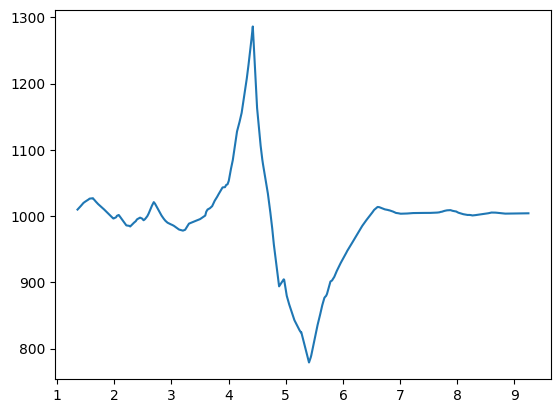

In [74]:
df_r1['MAGNITUDO'].plot()

In [76]:
tmp = df_r1.groupby(by='group_0.25_sec').agg(
    sloap=('MAGNITUDO', sloap),
    mean=('MAGNITUDO', 'mean')
)

/tmp/ipykernel_116406/439975347.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp = df_r1.groupby(by='group_0.25_sec').agg(


In [80]:
tmp.shift(2)

,sloap,mean
group_0.25_sec,,
0,NaN,NaN
1,NaN,NaN
2,77.907985,1018.124276
3,-87.071877,1020.473358
4,11.622516,998.983836
5,30.794341,986.421781
6,30.309512,996.432223
7,-109.982101,1013.163777
8,-56.175005,989.336867


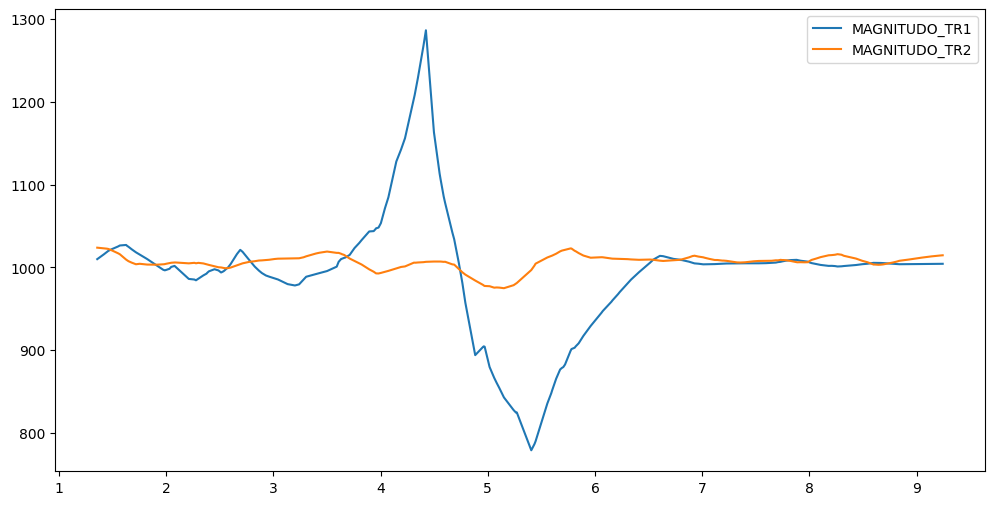

In [45]:
cols = [
   # 'MAGNITUDO_dt_dt_TM1', 
   'MAGNITUDO_TR1', 
   # 'MAGNITUDO_dt_dt_TM2', 
   'MAGNITUDO_TR2'
]
for i, c in enumerate(cols):
   # df_.query('OFFSET_s > 32 & OFFSET_s < 45')[c].plot(label=c,) #ylim=(500,1500))
   df_[c].plot(label=c,) #ylim=(500,1500))

fig = plt.gcf()
fig.set_size_inches((12,6))
plt.legend()


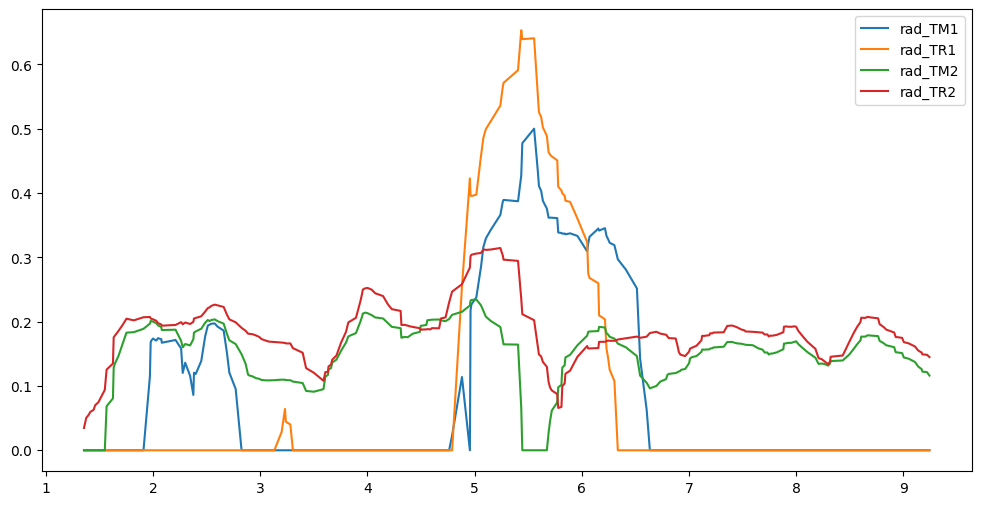

In [13]:
cols = ['rad_TM1', 'rad_TR1', 'rad_TM2', 'rad_TR2']
for i, c in enumerate(cols):
   # df_.query('OFFSET_s > 30 & OFFSET_s < 60')[c].plot(label=c)
   df_[c].plot(label=c)

fig = plt.gcf()
fig.set_size_inches((12,6))
plt.legend()


In [49]:
# cols = ['std_MAGNITUDO', 'mean_MAGNITUDO']
# fig, axes = plt.subplots(len(cols), 1)
# fig.set_size_inches((12,6))
# fig
# for i, c in enumerate(cols):
#    df[c].plot(ax=axes[i], title=c, sharey=True)


In [10]:
from sklearn.cluster import DBSCAN, MeanShift
from sklearn.decomposition import PCA

In [11]:
df

std_MAGNITUDO  mean_MAGNITUDO  std_MAGNITUDO_dt  \
group_0.25_sec type                                                    
0              AN         0.034950        0.524032          0.026655   
               M1         0.042554        0.551447          0.053216   
               M2         0.026822        0.570788          0.052628   
               R1         0.071065        0.552124          0.088623   
               R2         0.036100        0.560669          0.063716   
...                            ...             ...               ...   
31             AN         0.000687        0.515671          0.006431   
               M1         0.001687        0.501311          0.001360   
               M2         0.009272        0.547675          0.001201   
               R1         0.000500        0.514211          0.004780   
               R2         0.007920        0.540103          0.007774   

                     mean_MAGNITUDO_dt  std_MAGNITUDO_dt_dt  \
group_0.25_sec type                                           
0              AN             0.050600             0.007659   
               M1             0.092894             0.018632   
               M2             0.096969             0.069388   
               R1             0.079978             0.081733   
               R2             0.064977             0.001540   
...                                ...                  ...   
31             AN             0.035154             0.003626   
               M1             0.021073             0.021446   
               M2             0.018327             0.005405   
               R1             0.024220             0.012429   
               R2             0.027097             0.018783   

                     mean_MAGNITUDO_dt_dt   std_rad  mean_rad  std_rad_dt  \
group_0.25_sec type                                                         
0              AN                0.059138  0.145179  0.300908    0.238747   
               M1                0.186671  0.000000  0.000000    0.256997   
               M2                0.103768  0.206945  0.012692    0.000000   
               R1                0.357898  0.000000  0.000000    0.272080   
               R2                0.127724  0.241159  0.116159    0.000000   
...                                   ...       ...       ...         ...   
31             AN                0.030510  0.003567  0.338290    0.054325   
               M1                0.029672  0.000000  0.000000    0.008832   
               M2                0.013998  0.067067  0.209297    0.024940   
               R1                0.024100  0.000000  0.000000    0.021685   
               R2                0.053327  0.052449  0.253030    0.000000   

                     mean_rad_dt  std_rad_dt_dt  mean_rad_dt_dt  \
group_0.25_sec type                                               
0              AN       0.506173       0.143707        0.230071   
               M1       0.544380       0.111325        0.164667   
               M2       0.000000       0.284536        0.352220   
               R1       0.674890       0.176088        0.251671   
               R2       0.000000       0.039046        0.104332   
...                          ...            ...             ...   
31             AN       0.720301       0.024784        0.688087   
               M1       0.932887       0.020669        0.928421   
               M2       0.777819       0.019272        0.940012   
               R1       0.920955       0.012599        0.987419   
               R2       0.000000       0.049746        0.754375   

                     std_rad_cross  mean_rad_cross  std_rad_cross_dt  \
group_0.25_sec type                                                    
0              AN         0.398927        0.232082          0.558801   
               M1         0.474269        0.138563          0.553076   
               M2         0.434421        0.134095          0.548670   
               R1         0.36

In [12]:
pca = PCA().fit(df)

In [13]:
sum(pca.explained_variance_ratio_[:6])

0.8429652365747766

In [14]:
cols = ['mean_MAGNITUDO', 'mean_rad']
ms = MeanShift()
ms.fit(df[cols])

MeanShift()

In [28]:
cols = ['mean_MAGNITUDO', 'mean_rad']
ms = DBSCAN(eps=0.01)
ms.fit(df[cols])

DBSCAN(eps=0.01)

In [29]:
ms.fit_predict(df[cols])

array([ 0,  2, -1,  2, -1,  1,  2,  3, -1,  0, -1, -1,  0,  2,  0,  1, -1,
        0, -1,  0,  0, -1,  0,  2,  1,  0, -1,  0,  2,  0,  0,  2, -1,  2,
        0,  0,  2, -1, -1,  0,  0,  2, -1,  2,  4,  0, -1, -1,  2,  3,  0,
       -1,  0, -1, -1,  0, -1,  0, -1,  0,  0, -1,  0, -1,  0,  0,  2,  0,
        2,  1,  0, -1,  1, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1, -1,  0,
        0, -1, -1, -1, -1,  0, -1,  0, -1,  3,  0, -1,  0, -1,  0,  0, -1,
        4,  2,  0,  0,  2, -1,  2,  0,  0,  2,  4,  2,  3,  0,  2,  3,  2,
        0,  0,  2,  0,  2,  0,  0,  2,  3,  2,  0,  0,  2,  0,  2,  0,  0,
        2,  4,  2, -1,  0,  2,  3,  2,  0,  0,  2,  0,  2,  0,  0,  2,  3,
        2,  0,  0,  2,  4,  2,  3])

In [31]:
df['pred'] = ms.fit_predict(df[cols])

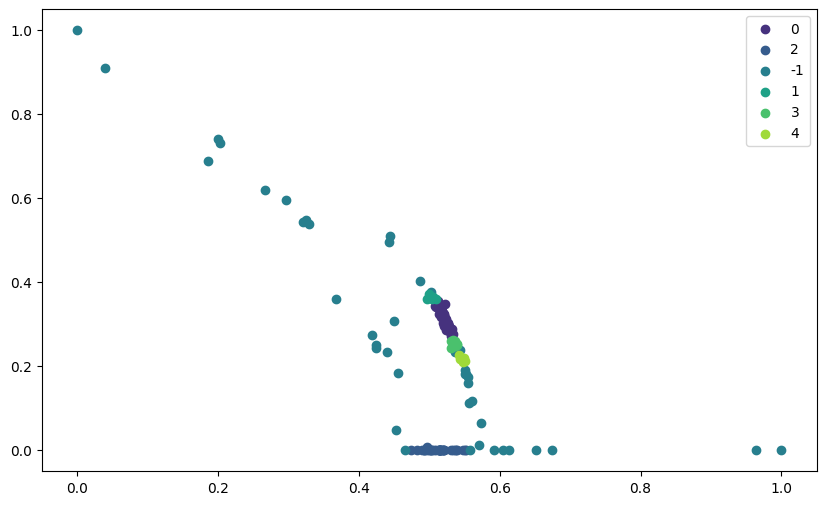

In [33]:
import seaborn as sns

unique_values = df['pred'].unique()
palette = sns.color_palette("viridis", as_cmap=False, n_colors=unique_values.size)
color_map = {val: palette[i] for i, val in enumerate(unique_values)}

plt.figure(figsize=(10, 6))
for value in unique_values:
    subset = df[df['pred'] == value]
    plt.scatter(subset['mean_MAGNITUDO'], subset['mean_rad'], label=value, color=color_map[value])
plt.legend()

# df[cols].plot.scatter('mean_MAGNITUDO', 'mean_rad',)

In [1]:
df.query('predict_ms_magnitudo == 0 & `type` == R1').reset_index()#.type.value_counts()

NameError: name 'df' is not defined

In [75]:
df_

,PAN,PT1,PT2,AxAN,AyAN,AzAN,AxTM1,AyTM1,AzTM1,AxTR1,...,rad_cross_dt_dt_TM1,rad_cross_dt_dt_TR1,rad_cross_dt_dt_TM2,rad_cross_dt_dt_TR2,rad_cross_dt_dt_AN,original_rad_cross_dt_dt_TM1,original_rad_cross_dt_dt_TR1,original_rad_cross_dt_dt_TM2,original_rad_cross_dt_dt_TR2,original_rad_cross_dt_dt_AN
1.357,101529.164777,101582.266636,101546.475943,310.538408,-917.513148,-291.527793,-852.489238,-539.661096,-81.155753,-601.450816,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1.378,101529.125005,101582.277750,101546.460479,309.116671,-916.582257,-293.050239,-855.839027,-537.322869,-81.929849,-601.221116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1.401,101529.080390,101582.289799,101546.443348,307.551417,-915.569029,-294.693267,-859.480593,-534.654838,-82.851493,-600.993051,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1.417,101529.048304,101582.298069,101546.431198,306.460720,-914.865677,-295.807667,-862.011390,-532.685500,-83.553483,-600.844866,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1.447,101528.984356,101582.313077,101546.407472,304.456346,-913.545241,-297.776431,-866.790087,-528.574582,-85.066144,-600.535393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.140,101528.061244,101581.737237,101544.639423,339.216178,-895.851424,-302.846239,-903.958164,-426.364305,13.321725,-483.653484,...,0.739107,1.514762,0.235731,0.413058,1.486362,0.000000,1.409097,0.0,0.0,1.183464
9.171,101528.070836,101581.707618,101544.660766,339.373066,-896.253762,-301.628887,-904.163051,-425.709315,13.336602,-483.057342,...,0.799720,1.538122,0.196112,0.299936,1.482953,1.025919,1.487208,0.0,0.0,1.364206
9.178,101528.072887,101581.700811,101544.665719,339.408742,-896.344629,-301.354942,-904.209716,-425.558582,13.337338,-482.921678,...,0.853472,1.554919,0.159829,0.203588,1.475646,1.027271,1.487427,0.0,0.0,1.358161
9.221,101528.084597,101581.658026,101544.697293,339.630412,-896.901779,-299.678811,-904.499290,-424.609497,13.323474,-482.079774,...,0.994950,1.580461,0.127151,0.122973,1.503181,1.453969,1.552043,0.0,0.0,1.522380


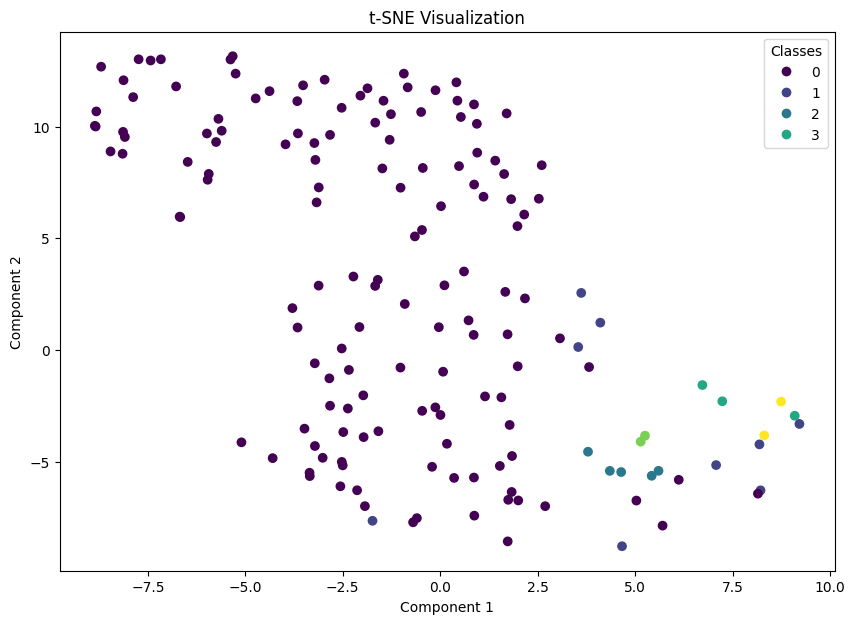

In [57]:
import numpy as np
import pandas as pd
# from sklearn.datasets import load_iris
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Carica il dataset Iris
# iris = load_iris()
X = df.values
# map_ = {'AN': 0, 'M1': 1, 'R1': 2, 'M2': 3, 'R2': 4}
map_ = {0: '0', 1: '1', 2: '2', 3: '3'}
# y = df.reset_index()['type'].map(map_)
y = df['predict_ms_magnitudo'].values

n_comp = 2 

# Applica t-SNE
tsne = TSNE(n_components=n_comp, random_state=42)
X_tsne = tsne.fit_transform(X)

# Crea un DataFrame per facilitare la visualizzazione
df_tsne = pd.DataFrame(X_tsne, columns=[f'Component {i}' for i in range(n_comp)])
df_tsne['Label'] = y

# Visualizza i risultati con matplotlib
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_tsne['Component 0'], df_tsne['Component 1'], c=df_tsne['Label'], cmap='viridis')
# scatter = plt.scatter(df_tsne['Component 1'], df_tsne['Component 2'], df_tsne['Component 3'], c=df_tsne['Label'], cmap='viridis')
plt.legend(handles=scatter.legend_elements()[0], labels=map_.keys(), title="Classes")
plt.title('t-SNE Visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
